## 1. 필요한 모듈 설치

In [1]:
!sudo apt install cmake
!pip install face_recognition

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import face_recognition
import numpy as np 
import pandas as pd
import seaborn as sns
from PIL import Image 

## 2. 이미지 준비

file_list: ['jungin.jpg', 'jungin1.jpg']


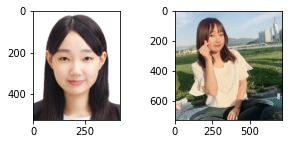

In [3]:
dir_path = '/content/drive/MyDrive/Github/AIFFEL/E05/'
my_dir_path = '/content/drive/MyDrive/Github/AIFFEL/E05/me/'
cel_dir_path = '/content/drive/MyDrive/Github/AIFFEL/E05/celebrity/'

file_list = os.listdir(my_dir_path)

print ("file_list: {}".format(file_list))

#Set figsize here
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,2))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  image = img.imread(my_dir_path+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

## 3. 얼굴 영역 자르기

In [4]:
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)

    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

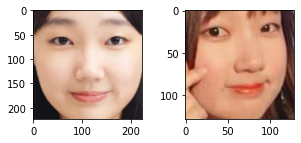

In [5]:
file_list = os.listdir(my_dir_path)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,2))

for i, ax in enumerate(axes.flatten()):
  cropped_face = get_cropped_face(my_dir_path+file_list[i])
  ax.imshow(cropped_face)
plt.show()


## 4. 얼굴 영역 임베딩 추출

In [6]:
# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

In [7]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = f'{dir_path}/{file}'
        try:
          face = get_cropped_face(img_path)
          embedding = get_face_embedding(face)
          if len(embedding) > 0:  
          # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
          # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
              embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        except:
            pass
    return embedding_dict

In [8]:
cel_embedding_dict = get_face_embedding_dict(cel_dir_path)  # celebrity face embedding dictionary
my_embedding_dict = get_face_embedding_dict(my_dir_path)    # my face embedding dictionary
cel_embedding_dict.update(my_embedding_dict) #병합
embedding_dict = cel_embedding_dict

## 5. 임베딩 벡터 간 거리 구하기

In [9]:
#두 이미지(사람 이름) 사이의 임베딩 벡터 거리를 구하는 함수
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

In [10]:
#name1과 name2의 거리를 비교, 반환
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [11]:
#임의의 이름에 대해 다른 이미지의 임베딩 거리를 정렬해서 출력하는 함수
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    i = 0
    rank = 1
    fig = plt.figure(figsize=(12, 10))
    fig.add_subplot(1, top, 1)
    image = img.imread(os.path.join(my_dir_path,name + '.jpg'))
    plt.imshow(image)
    
    result = []
    while rank<=top:
      if 'jungin' in sorted_faces[i][0]: #except for my name 
        i+=1
        continue
      if sorted_faces[i]:
          result.append({ 'rank' : rank, 'name': sorted_faces[i][0], 'distance':sort_key_func(sorted_faces[i][0])})
          print('순위 {} : 이름: {}, 거리({})'.format(rank, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
          image = img.imread(os.path.join(cel_dir_path, sorted_faces[i][0] + '.jpg'))
          fig.add_subplot(2, top, rank + top)
          plt.imshow(image)
          i+=1
          rank+=1


## 6. 시각화

순위 1 : 이름: 김혜윤, 거리(0.33212064396174634)
순위 2 : 이름: 김윤희, 거리(0.3435835614275043)
순위 3 : 이름: 류아벨, 거리(0.3439614724205822)
순위 4 : 이름: 소아린, 거리(0.345580777135149)
순위 5 : 이름: 이연수, 거리(0.347645050764185)


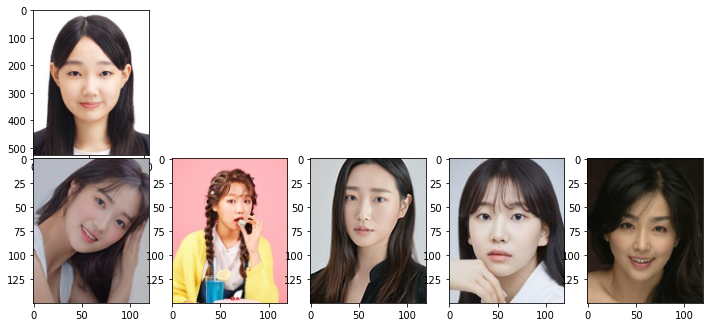

In [12]:
get_nearest_face('jungin')

순위 1 : 이름: 김윤희, 거리(0.3558689545666669)
순위 2 : 이름: 김보민, 거리(0.36382409577667735)
순위 3 : 이름: 정다빈, 거리(0.366090916501398)
순위 4 : 이름: 심은하, 거리(0.37306312527849866)
순위 5 : 이름: 송민재, 거리(0.37654386158397035)


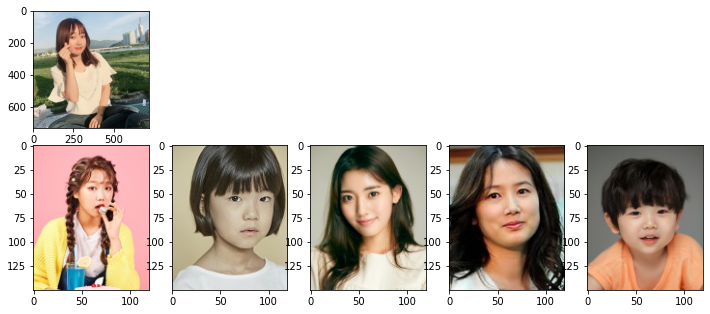

In [13]:
get_nearest_face('jungin1')